## Pairs trading by cointegration in forex

---
In this project I want to test whether it is possible to utilize a feasible trading strategy using cointegration. Previously it has been proven that two pairs of assets that tend to be cointegrated, that is tend to follow the same trend and over time keep a spread within a boundary. When the spread widens it also tends to seek back to the mean. The plan is to trade taht spread as it is wide to expect it to return to the mean. We can do that by buying one asset and selling the other asset. In theory it should give some sort of return with a low risk as we hedge the trade (buy one and sell another asset).

I have chosen to use forex pairs as they don't need to be adjusted for dividens etc., and they are very liquid thus making them easier to enter and exit in contrast to a low liquid stock from a small company. A thing to remember when using forex as asstes to this strategy is that we actualle trade two pairs as one asset consists of two currencies like AUDUSD vs. NZDUSD, which is the Australien dollar vs. US dollar hedged againt New Zealand dollar vs. US dollar. 

The first thing we are going to do is to test which pairs are correlated and cointegrated. Be aware that a pair can be highly correlated but not cointegrated and in that cas won't be a good candidate for pairs trading using this strategy.

Then we select a good candidate and simulate trading to find the optimal parameters for our lookback period and when to bue and sell the assets in relation to the spread.

---

#### 1. Import libraries and define parameters for data load

In [1]:
import pandas as pd
import numpy as np
from itertools import combinations, product
from heatmap import corrplot
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.regression.linear_model import OLS
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
from sklearn import linear_model
from arch.unitroot import ADF, engle_granger
from Plot_timeformat import CustomFormatter
from numpy.lib.stride_tricks import sliding_window_view as view

%config Completer.use_jedi = True
%config InlineBackend.figure_format = 'retina' # Get nicer looking graphs for retina displays

sns.set_style('white')

In [2]:
FOLDER = "D:/data/raw/h1_2022/"
COLS = ['Open','High','Low','Close','Volume']
symbols = ['AUDCAD', 'AUDCHF', 'AUDJPY', 'AUDNZD', 'AUDUSD', 'CADCHF', 'CHFJPY', 'EURJPY', 'EURUSD', 'GBPJPY', 'GBPUSD', 'NZDUSD', 'USDCAD', 'USDCHF', 'USDJPY', 'XAGUSD', 'XAUUSD']

In [3]:
def load_pairs(symbols):
    data = {}
    for symbol in symbols:  
        data[symbol] = pd.read_csv(f"{FOLDER}2022.1.18{symbol}_UTCPlus02-H1-No Session.csv", parse_dates=[['Date', 'Time']], index_col='Date_Time')
        data[symbol].index = pd.to_datetime(data[symbol].index, format="%Y-%m-%d-%H").to_period('H')
        data[symbol].drop(['Open', 'Volume'], inplace=True, axis=1)
    df = pd.concat(data, keys=(symbols), axis=1).dropna()
    df = df[df.index.dayofweek < 5]
    return df

In [4]:
def get_close(df):
    df_close = df.loc[:, (slice(None), 'Close')]
    df_close = df_close.droplevel(axis=1, level=1)
    return df_close

In [5]:
# Helper function for converting datetime index from period to ordinary datetime

def ts_convert(df):
    new_df = df.reset_index()
    new_df['Date_Time'] = new_df['Date_Time'].dt.to_timestamp()
    df_formatter = CustomFormatter(new_df['Date_Time'])
    return df_formatter

In [6]:
data = load_pairs(symbols)

In [7]:
df_close = get_close(data)

---
Every asset is loaded as 1 hour bars containing "Open", "Close", "High", "Low" and "Volume". In this strategy we will only use the closing price of each bar.

#### 2. Check which assets are correlated as it can give us a hint of which pairs are cointegrated.
In the correlationplot below the correlation is shown by how big the square is. The bigger the square, the higer correlation. 

---

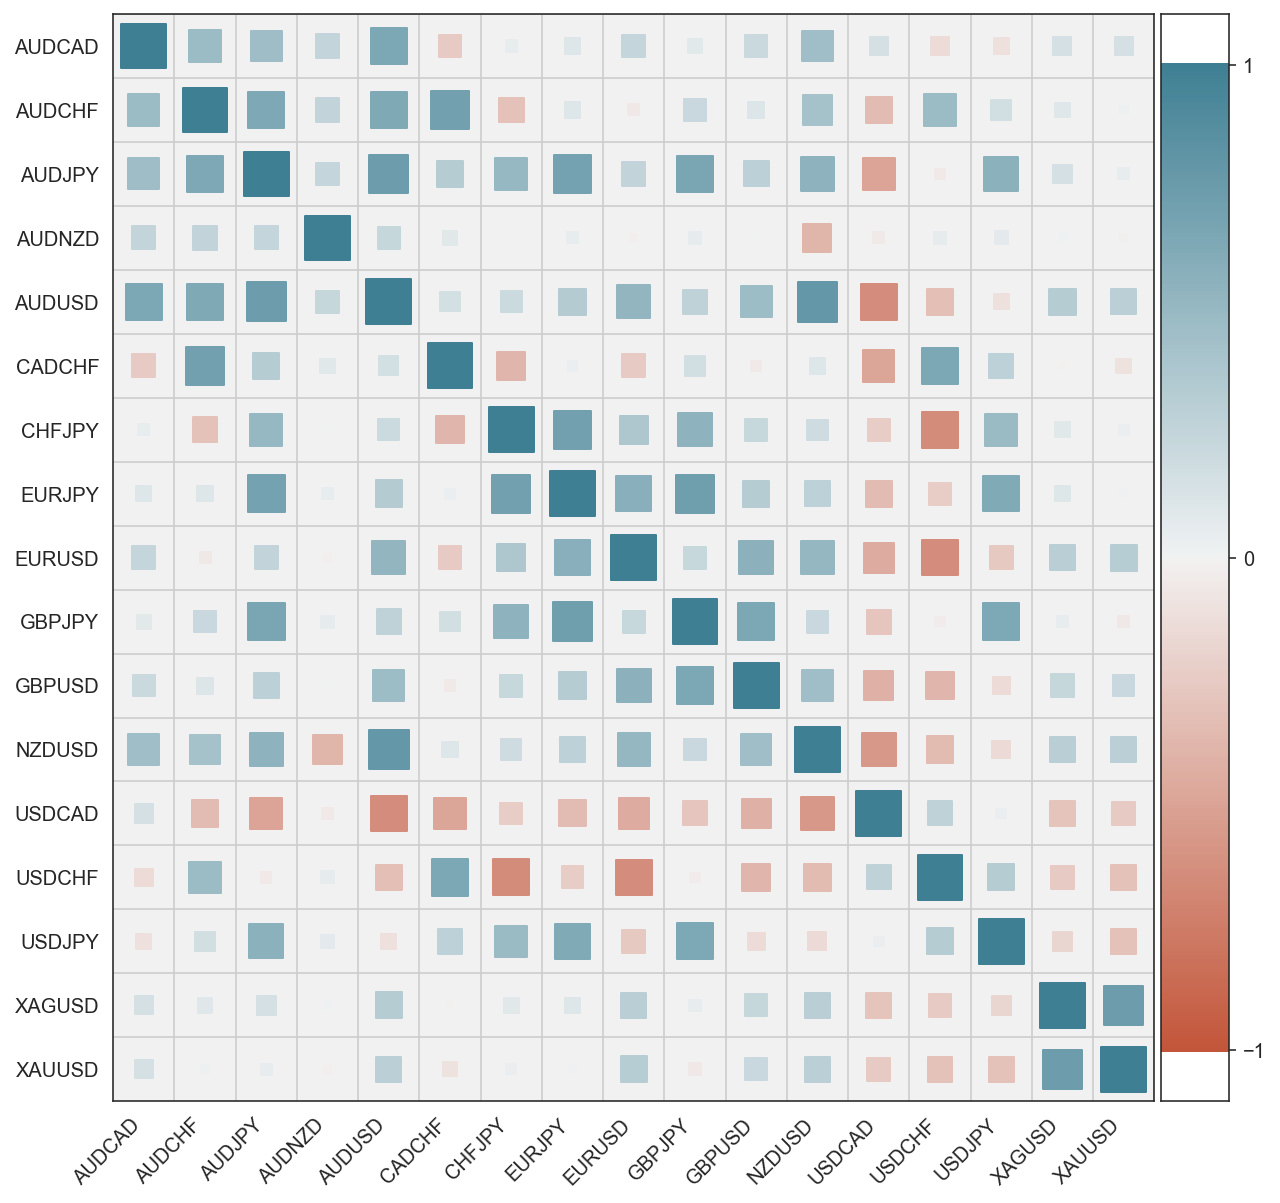

In [8]:
df_returns = df_close.pct_change().dropna()
df_corr = df_returns.corr()
plt.figure(figsize=(10, 10))
corrplot(df_corr)

---
Let's plot one of the correlated pairs to see if the price are actually following the same pattern. <br />
When you look at it it seems as if they're mostly following the same pattern in the beginning and then by the end it starts 
to move away from each other. <br /> But that's actually not a problem as we will look at their pattern in a much smaller "window" than the four year period shown below. Let's also plot the last plot in a smaller window. 

---

In [9]:
df_returns

,AUDCAD,AUDCHF,AUDJPY,AUDNZD,AUDUSD,CADCHF,CHFJPY,EURJPY,EURUSD,GBPJPY,GBPUSD,NZDUSD,USDCAD,USDCHF,USDJPY,XAGUSD,XAUUSD
Date_Time,,,,,,,,,,,,,,,,,
2010-01-01 01:00,0.000000,0.000000,0.000048,-0.000146,-0.000067,0.000000,-0.000011,0.000375,-0.000021,-0.000013,0.000025,-0.000028,-0.000095,0.000039,0.000108,0.000594,0.000018
2010-01-01 02:00,-0.000350,0.000636,-0.000228,-0.000259,0.003545,0.000071,-0.000212,-0.000435,-0.000049,-0.000339,-0.000006,0.000028,0.000114,0.000077,-0.000215,-0.004688,-0.000192
2010-01-01 03:00,0.000064,0.000011,-0.000731,0.000478,-0.000011,0.000020,0.000089,0.000450,-0.000188,0.000253,-0.000006,-0.000400,-0.000238,-0.000058,-0.000075,0.003578,0.000219
2010-01-01 04:00,0.000000,-0.000022,0.000755,-0.000251,0.000011,0.000010,0.001660,0.000038,0.000202,0.000073,0.000049,0.000497,0.000190,-0.001053,0.000075,-0.001010,-0.000036
2010-01-01 05:00,-0.000085,0.000043,-0.000216,-0.000024,0.000000,0.000071,-0.000311,-0.000510,-0.000482,-0.000479,-0.000414,0.000234,0.000029,-0.000135,0.000032,0.001427,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-14 20:00,0.000221,-0.000197,0.000170,-0.000472,0.000236,-0.000385,0.000344,0.000584,0.000675,0.000995,0.001076,0.000751,-0.000040,-0.000449,-0.000096,-0.000131,0.000705
2022-01-14 21:00,0.000398,0.000684,0.000791,-0.000661,0.000597,0.000289,0.000120,0.000691,0.000482,0.000667,0.000468,0.001235,-0.000167,0.000120,0.000228,0.001923,0.000622
2022-01-14 22:00,0.000464,0.001048,0.001556,0.000897,0.001110,0.000591,0.000536,0.000361,-0.000035,0.000647,0.000183,0.000220,-0.000685,-0.000142,0.000412,0.000524,-0.001034


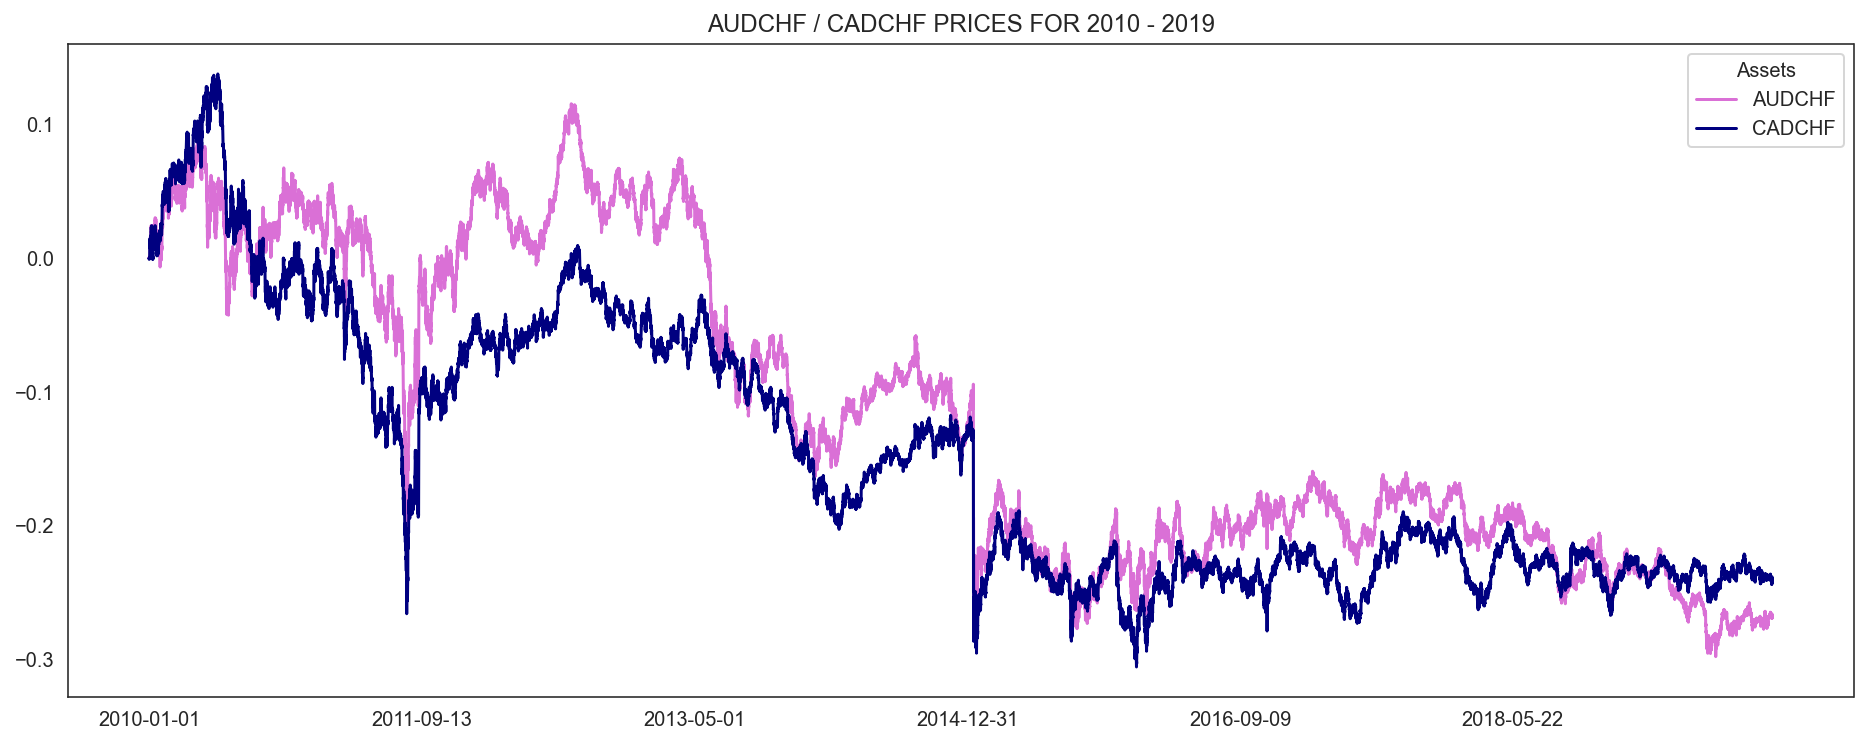

In [10]:
def plot_assets(df, pair, YEAR, YEAR_END):
    df_formatter = ts_convert(df.loc[YEAR:YEAR_END])
    fig, ax = plt.subplots(figsize=(16,6))
    ax.xaxis.set_major_formatter(df_formatter)
    ax.plot((1+df.loc[YEAR:YEAR_END,pair[0]]).values.cumprod()-1, color='orchid', label='AUDCHF')
    ax.plot((1+df.loc[YEAR:YEAR_END,pair[1]]).values.cumprod()-1, color='navy', label='CADCHF')
    plt.title(f'{pair[0]} / {pair[1]} PRICES FOR {YEAR} - {YEAR_END}')
    plt.legend(title='Assets')
    plt.show()

PAIR = ['AUDCHF', 'CADCHF']
plot_assets(df_returns, PAIR, '2010', '2019')

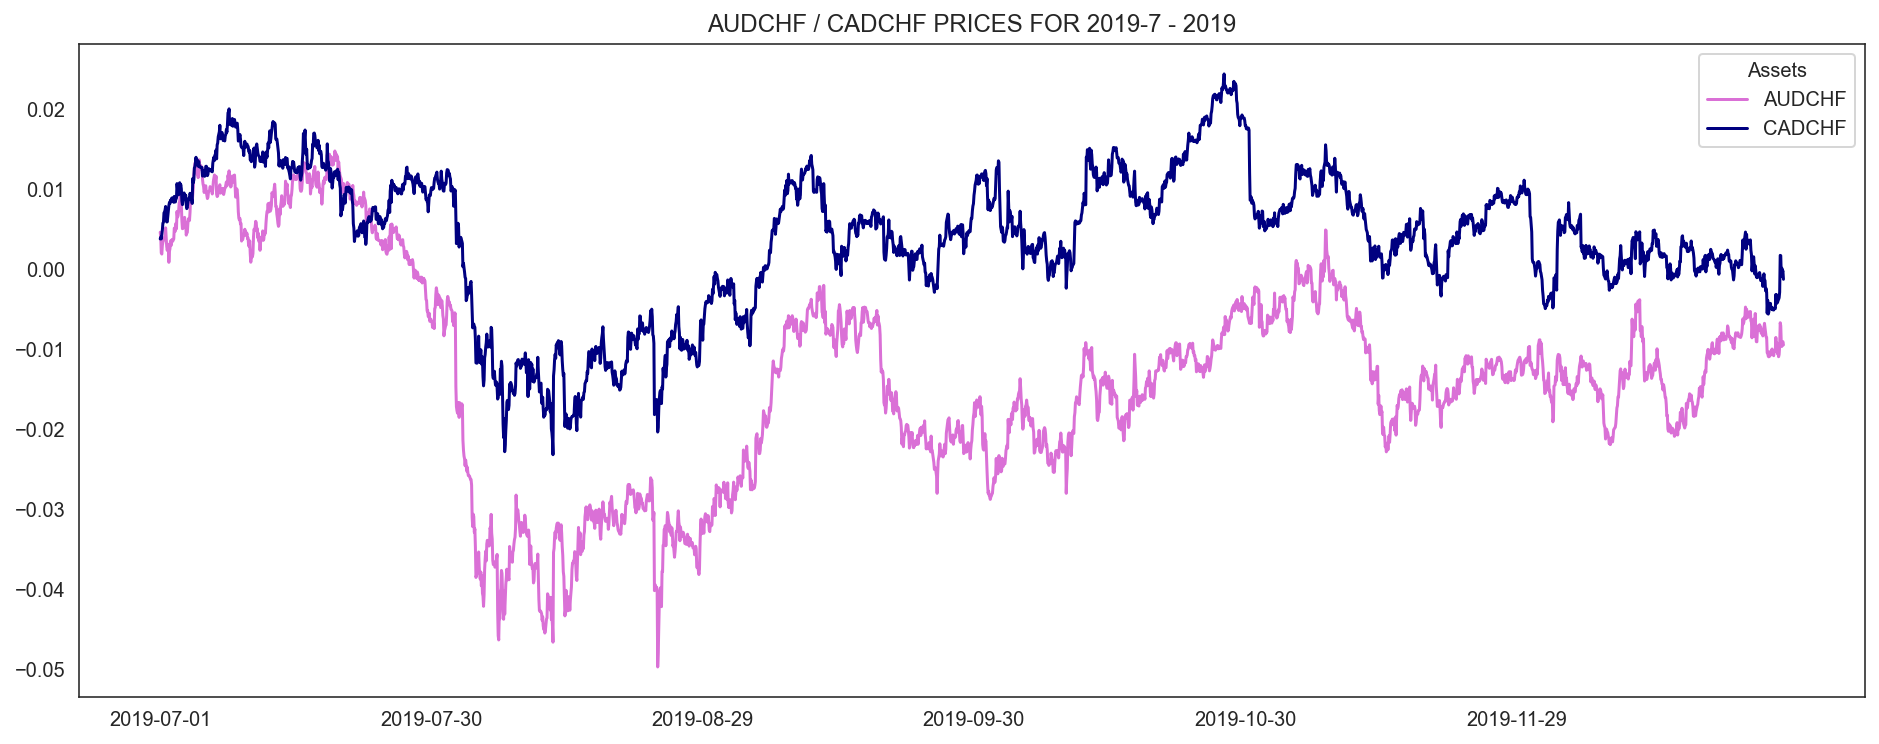

In [11]:
plot_assets(df_returns, PAIR, '2019-7', '2019')

---
Prices are actually still pretty correlated (and also cointegrated as it will later show) -as long as we model the data using a smaller window, which is excatly what we will do.

#### 3. Check for cointegration between the pairs
To begin with we are going to use the four year training data to test for cointegration. The first step is to calculate the ratio at which the two pairs change.<br /> We can calculate that by doing a simple linear regression and using the coefficient to get the residuals, which is the spread we are looking for.<br />
<br />
The spread shows us how big the distance is between the two pairs. When the spread widens we can decide to take on a trade with the expectation that it,<br /> at some point, will revert back to the mean of the spread.

---

In [12]:
YEAR = '2016'
YEAR_END = '2019'
def get_spread(df):
    X = np.log(df.loc[YEAR:YEAR_END,PAIR[0]])
    X = np.expand_dims(np.array(X), axis=1)
    y = np.log(df.loc[YEAR:YEAR_END,PAIR[1]])
    regr = linear_model.LinearRegression().fit(X, y) 
    beta = regr.coef_[0]
    alpha = regr.intercept_
    spread = y.values - np.squeeze(X) * beta + alpha
    return spread, beta

In [13]:
spread, beta = get_spread(df_close)

---
Now we have the spread we can test the spread for a unit root. If it doesn't the pairs are cointegrated. So our Null hypothesis is that the pairs have a unit root and our alternative hyposis is that it doesn't. <br />
To test for unit root we use the Augmented Dickey-Fuller test. <br />
The result we get is a T-statistics of -3.860 which is lower than all of the 10%, 5% and 1% tests and thus the pairs are cointegrated.

---

In [14]:
adf = ADF(spread)
adf.summary()

Test Statistic,-3.860
P-value,0.002
Lags,11


---
Now , let's have a look at how the spread is distributed. As expected the values is close to be normal distributed. <br /> 
The plan is to enter a trade when the value reaches some threshold eg. two standard deviations from the mean. <br />
To make it easier to relate to and define we are going to normalize the spread by calculating the Z-score.

---

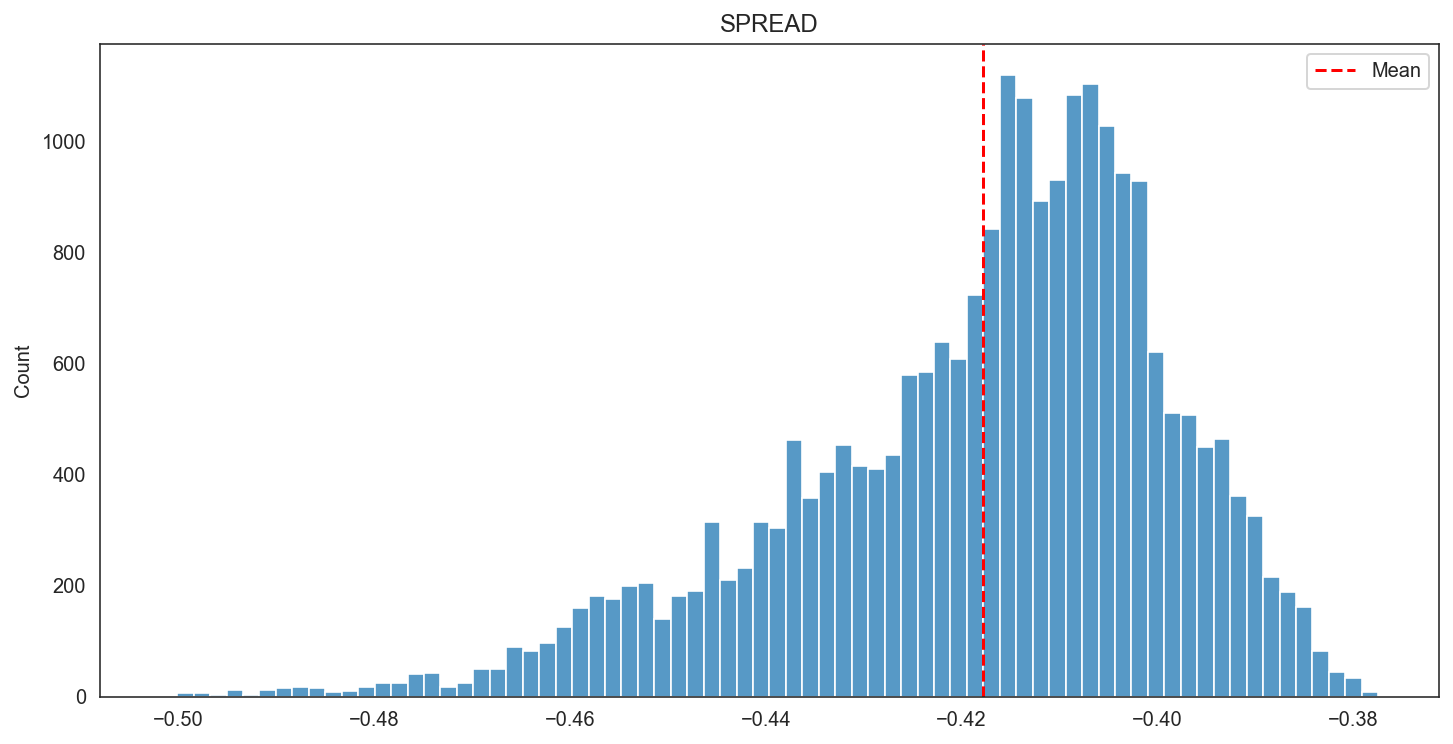

In [15]:
fig, ax = plt.subplots(figsize=(12,6))
sns.histplot(spread, ax=ax)
ax.set(title="SPREAD")
ax.axvline(x=spread.mean(), label='Mean', linestyle='--', color='r')
ax.legend()
plt.show()

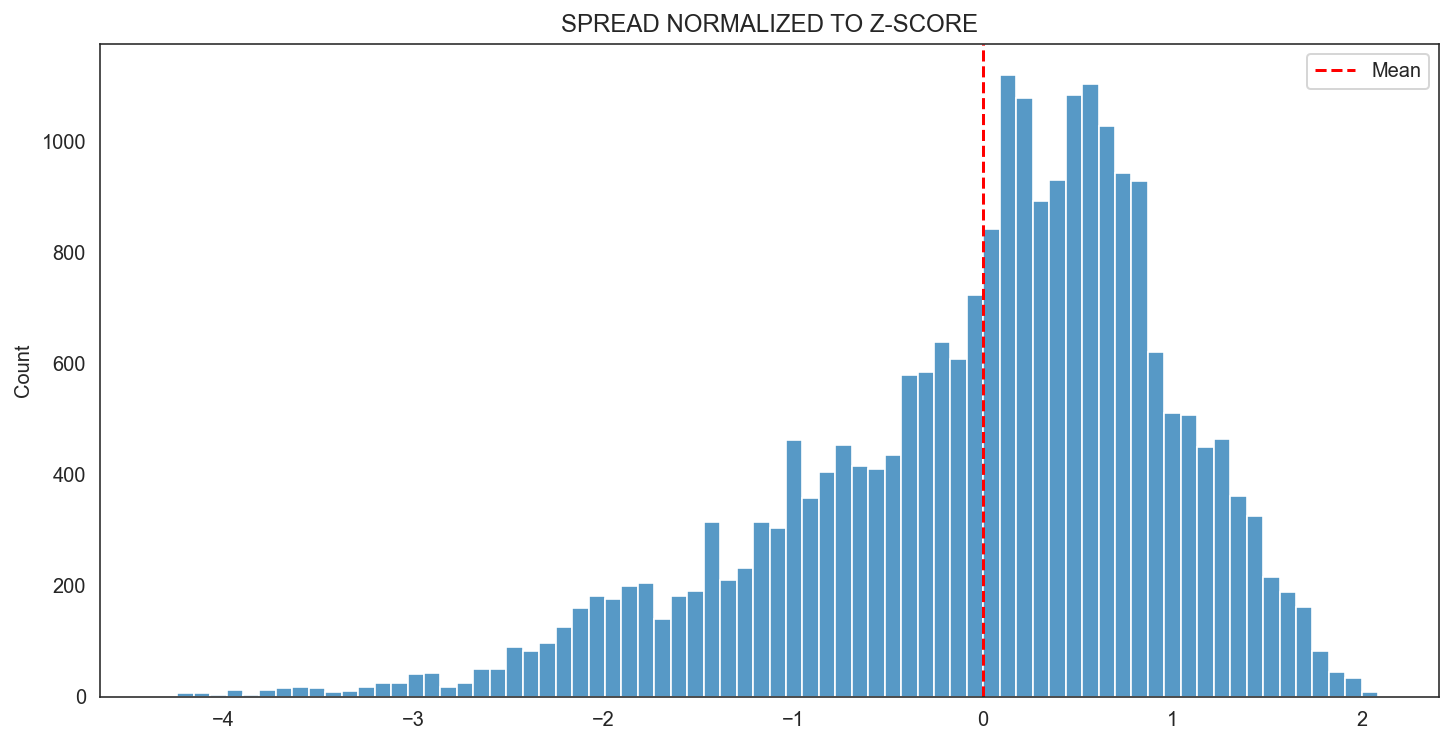

In [16]:
Z_score = (spread - spread.mean()) / np.std(spread)

fig, ax = plt.subplots(figsize=(12,6))
sns.histplot(Z_score, ax=ax)
ax.axvline(x=0, label='Mean', linestyle='--', color='r')
ax.legend()
ax.set(title="SPREAD NORMALIZED TO Z-SCORE")
plt.show()

---
We can take a look below at how the spread moves in relation to the two assets. As the spread widens, the Z-score moves away from the mean (0).

---

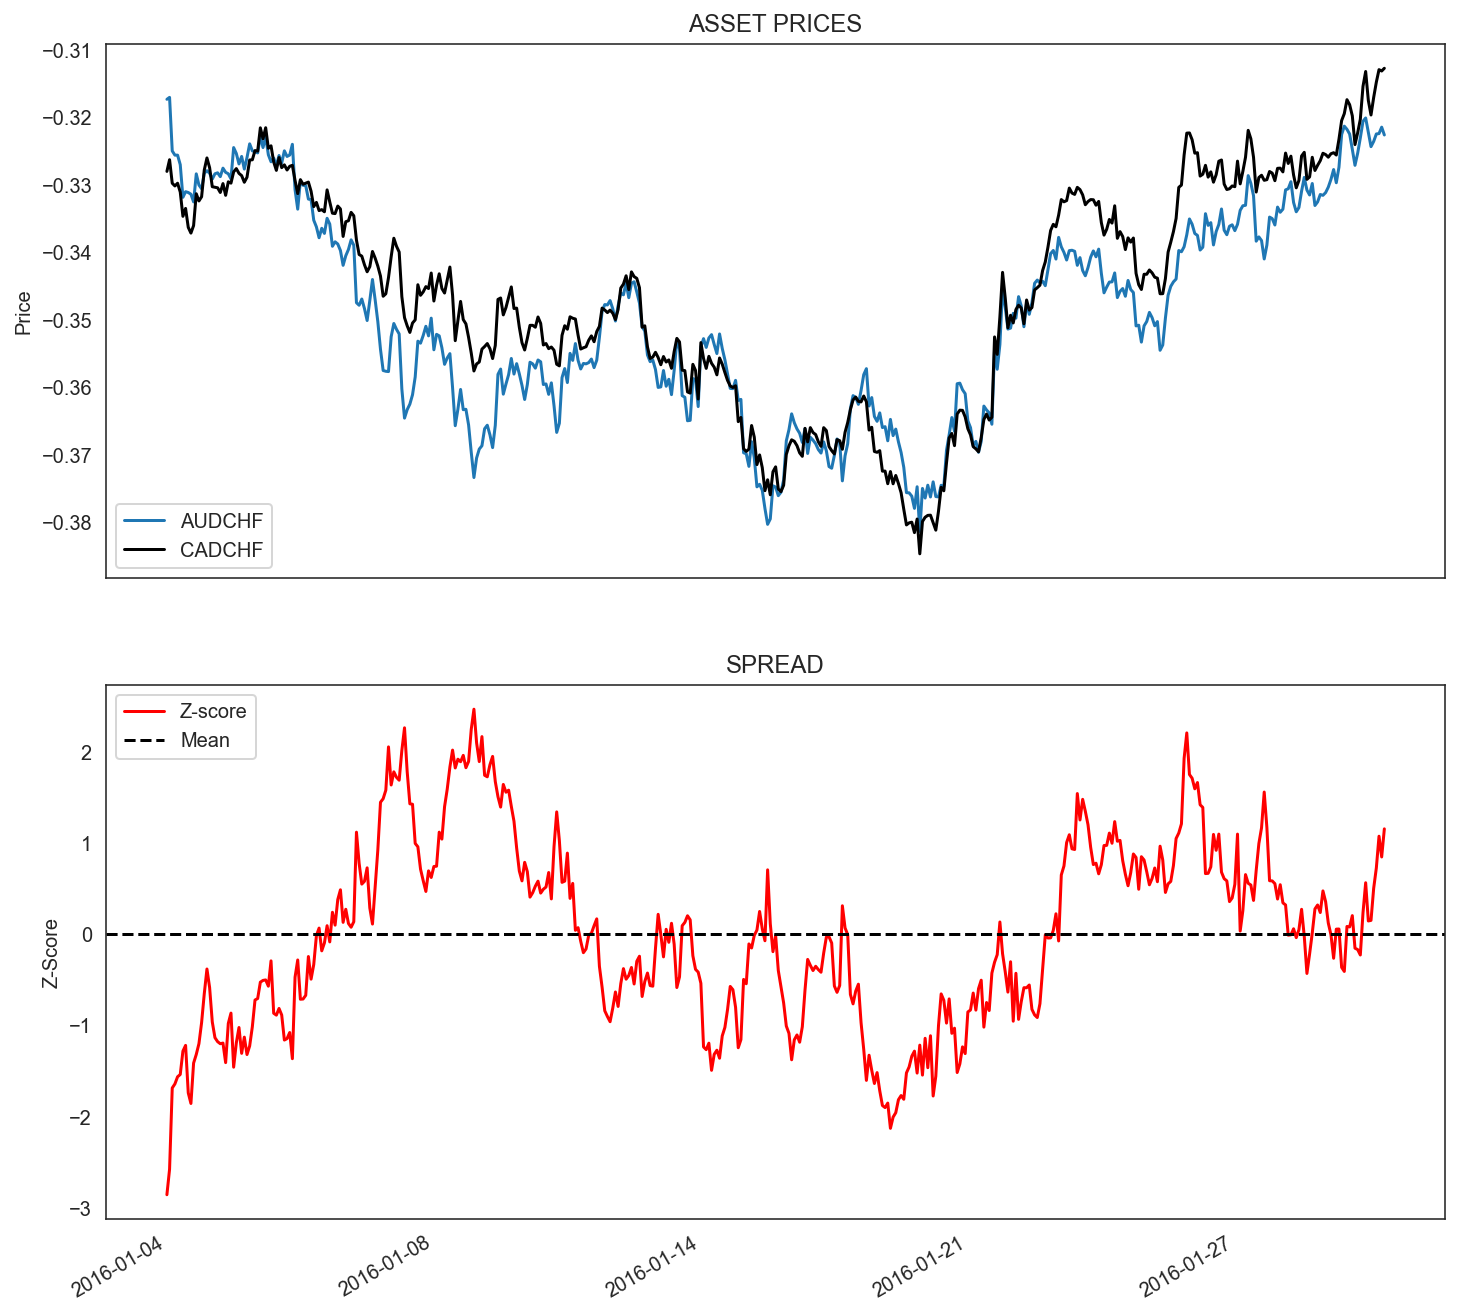

In [17]:
def regression(x,y):
        reg = linear_model.LinearRegression()
        x_constant = np.column_stack([np.ones(x.shape[0]), x])
        reg.fit(x_constant, y)
        beta = reg.coef_[1]
        alpha = reg.intercept_
        spread = y - x*beta + alpha
        return spread, beta

# Calculate Z-score for shorter period
coint = np.log(df_close.loc['2016':'2016-1',PAIR])
spread, beta = regression(coint[PAIR[0]], coint[PAIR[1]])
Z_score = (spread - spread.mean()) / np.std(spread)

df_formatter = ts_convert(coint)

# Plot data
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(12,12))
ax1.xaxis.set_major_formatter(df_formatter)
ax1.plot(np.arange(len(coint)), coint['AUDCHF'], label='AUDCHF')
ax1.plot(np.arange(len(coint)), coint['CADCHF'], color='k', label='CADCHF')
ax2.plot(np.arange(len(coint)), Z_score, color='r', label='Z-score')
ax2.axhline(0, color='black', label='Mean', linestyle='--')
ax1.set_title('ASSET PRICES')
ax2.set_title('SPREAD')
fig.autofmt_xdate()
ax1.set(ylabel='Price')
ax2.set(ylabel='Z-Score')
ax1.legend(loc="lower left")
ax2.legend(loc="upper left")
plt.show()

---
#### Systematic cointegration test for multiple assets

Now lets test all of our assets and pair-wise test if they are cointegrated. <br />
I have created two funtion. The first one test for correlation. We could use that to get a hint of which pairs to take a closer look at. <br />
Next I have created a function (check_cointegration) that runs through all the pair-wise combinations and checks them for cointegration. The function returns a dataframe with stats on all the pairs.

---

In [18]:
def check_correlation(data, symbols):
    df_returns = data.pct_change().dropna()
    df_corr = df_returns.corr()
    sorted_mat = df_corr.unstack().sort_values(ascending=False)
    corr_pairs = sorted_mat[(abs(sorted_mat) > 0.7) & (abs(sorted_mat) < 1.0)].iloc[::2]
    print(corr_pairs)
    return sorted_mat

In [19]:
def check_cointegration(df, corr_pairs, start, end):
    
    if isinstance(corr_pairs, list):
        corr_pairs = list(combinations(symbols, 2))
    else:
        corr_pairs = list(corr_pairs.index)
    
    result = pd.DataFrame(columns=['X', 'y', 'P_value', 'Coef', 'Test', '1 %', '5 %', '10 %'], index=list(range(len(corr_pairs)*2)))
    dfs = {}
    df_log = np.log(df.loc[start:end,:])
    i = 0
    
    for pair in corr_pairs:
        pair = list(pair)
        df_pair = df_log.loc[:,pair]
        df_pair = sm.add_constant(df_pair)
        for symbol in pair:
            spread = pd.Series(dtype='float64')
            X = df_pair.loc[:, df_pair.columns != symbol].values
            y = df_pair[symbol].values.reshape(-1,1)
            reg = sm.OLS(y, X).fit()
            spread = y - (X[:,1:2] * reg.params[1])
            adf = ADF(spread.reshape(-1,), lags=1)
            result.iloc[i]['X'] = pair[1 - i%2]
            result.iloc[i]['y'] = symbol
            result.iloc[i]['P_value'] = adf.pvalue
            result.iloc[i]['Coef'] = reg.params[1]
            result.iloc[i]['Test'] = adf.stat
            result.iloc[i]['1 %'] = list(adf.critical_values.values())[0]
            result.iloc[i]['5 %'] = list(adf.critical_values.values())[1]
            result.iloc[i]['10 %'] = list(adf.critical_values.values())[2]
            prev_spread = spread
            if i%2 == 1 and result.iloc[i]['P_value'] > result.iloc[i-1]['P_value']:
                spread = prev_spread
            i +=1
        df_pair = df_pair.loc[:,pair]
        df_pair['Spread'] = spread
        dfs['-'.join(pair)] = df_pair

    df = pd.concat(dfs, keys=(dfs.keys()), axis=1).dropna()
    result
    return result, df

In [20]:
corr_pairs = check_correlation(df_close, symbols)

AUDUSD  NZDUSD    0.789202
AUDJPY  AUDUSD    0.747698
XAGUSD  XAUUSD    0.746294
GBPJPY  EURJPY    0.732909
EURJPY  CHFJPY    0.717432
CADCHF  AUDCHF    0.716128
dtype: float64


In [21]:
result, dfs = check_cointegration(df_close, symbols, start='2010', end='2019')

---
Below is the returned dataframe. <br />

**"10 %" is the threshold for the 90% confidence interval**<br />
**"5 %" is the threshold for the 95% confidence interval**<br />
**"1 %" is the threshold for the 99% confidence interval**<br />
**"Test" is the test statistic, or threshold, we use to define the confidence for our cointegration test**<br />
**"Coef" is the coefficient returned fomr the linear regression. We use this to calculate the spread and as a ratio between the trades sizes of the two assets.**<br />


Because the test returns a lot of cointegrated pairs we can be very picky and only show pairs that are cointegrated with 99% confidence, ie. the P-value is lower than 0.01<br />

Now we have a list of all the possible cointegrated pairs. Next we will choose a pair to focus on and test to find the optimal Z-score (Standard deviation) for our trades.

---


In [22]:
result[result['P_value'] < 0.01].sort_values(['P_value']).head(30)

,X,y,P_value,Coef,Test,1 %,5 %,10 %
52,USDCAD,AUDCHF,0.000936,-0.956148,-4.10905,-3.43046,-2.861589,-2.566796
245,NZDUSD,USDCHF,0.001376,-0.438031,-4.006723,-3.43046,-2.861589,-2.566796
53,AUDCHF,USDCAD,0.001433,-0.908233,-3.995684,-3.43046,-2.861589,-2.566796
25,AUDCAD,USDCHF,0.001502,-0.77691,-3.983004,-3.43046,-2.861589,-2.566796
28,XAGUSD,AUDCAD,0.002424,0.093728,-3.851352,-3.43046,-2.861589,-2.566796
24,USDCHF,AUDCAD,0.002709,-0.440763,-3.820038,-3.43046,-2.861589,-2.566796
267,USDJPY,XAGUSD,0.003037,-1.792985,-3.787592,-3.43046,-2.861589,-2.566796
93,AUDNZD,CADCHF,0.003134,1.129307,-3.77857,-3.43046,-2.861589,-2.566796
20,NZDUSD,AUDCAD,0.003266,0.33214,-3.76681,-3.43046,-2.861589,-2.566796
110,USDJPY,AUDNZD,0.003731,-0.523484,-3.728435,-3.43046,-2.861589,-2.566796


---
#### Finding the optimal thresholds for trades

From the above results I have chosen to use the two assets "USDCAD" and "AUDCAD" as our trading pair as they have the same basecurrency ("CAD"). <br />
If we would go on and start trading this pair it will make things simpler and potentially cheaper in commission to have the same base currency.

To find the optimal lookback window size and threshold for entering and exiting trades we will simulate trading using the different parameters. <br />
First step is to calculate the spread using different windowsizes and then we will utilize a trade-engine function which will simulate trades at defined entry and exit thresholds.

We are going to create 189 different models and runs each them through our trade-engine. That is going to take some time, but it's time well spent to get the insight of which paramters works the best.<br />
To speed the processes up at much as possible, within the boundries of running it on my local machine, I have focused on uptimizing the code to run faster.

---

In [23]:
# Function to create a model based on pair input and window size for the rolling window

def CreateModel(p1, p2, pair, window):   
    reg_df = pd.DataFrame()
    reg_df['X_p1'] = np.log(p1.loc[:,'Close'])
    reg_df['y_p2'] = np.log(p2.loc[:,'Close'])

    reg = RollingOLS.from_formula('y_p2 ~ X_p1 -1', window=window, data=reg_df).fit()
    ratio = reg.params[window:].values

    X = reg_df['X_p1'] 
    y = reg_df['y_p2']

    df_window = view(reg_df, window, axis=0)
    spreads = [df_window[i,1] - (ratio[i] * df_window[i,0]) for i in range(df_window.shape[0]-1)]
    short_mean= [x[-3:].mean() for x in spreads]
    mean= [x.mean() for x in spreads]
    std= [x.std() for x in spreads]
    y = [v[-1] for v in spreads]
    Z = (np.array(short_mean) - np.array(mean)) / np.array(std)
    
    return Z

In [24]:
# A class to act as our trading evironment to buy and sell the pairs

class TradeEngine:
    def __init__(self, pair, p1, p2, Z, threshold, window, exit):
        self.p1 = p1.iloc[window:,:]
        self.p2 = p2.iloc[window:,:]
        self.PAIR = pair
        self.Z = Z
        self.threshold = threshold
        columns = pd.MultiIndex(levels=[self.PAIR, list(['Entry', 'Exit', 'Profit', 'Drawdown'])], codes=[[0,0,0,0,1,1,1,1],[0,1,2,3,0,1,2,3]])
        self.trades = pd.DataFrame(index=self.p1.index, columns=columns)
        self.direction = None
        self.reset = [99, -1]
        self.P1_MinMax = self.reset
        self.P2_MinMax = self.reset
        self.p1_profit = []
        self.p2_profit = []
        self.p1_entry = 0
        self.p2_entry = 0
        self.exit = exit
        self.symbol_factor = 10000
        
    def entry(self, i):
        self.p1_entry = self.p1['Close'].iloc[i]
        self.p2_entry = self.p2['Close'].iloc[i]
        self.trades.loc[self.p1.iloc[i].name, self.PAIR[0]]['Entry'] = self.p1_entry
        self.trades.loc[self.p2.iloc[i].name, self.PAIR[1]]['Entry'] = self.p2_entry

    def close(self, i):
        if self.direction == 'long':
            self.p1_profit.append((self.p1['Close'].iloc[i] - self.p1_entry) * self.symbol_factor)
            self.p2_profit.append((self.p2_entry - self.p2['Close'].iloc[i]) * self.symbol_factor)
            self.trades.loc[self.p1.iloc[i].name, self.PAIR[0]]['Exit'] = self.p1['Close'].iloc[i]
            self.trades.loc[self.p2.iloc[i].name, self.PAIR[1]]['Exit'] = self.p2['Close'].iloc[i]
            self.trades.loc[self.p1.iloc[i].name, self.PAIR[0]]['Profit'] = self.p1_profit[-1]
            self.trades.loc[self.p2.iloc[i].name, self.PAIR[1]]['Profit'] = self.p2_profit[-1]
            self.trades.loc[self.p1.iloc[i].name, self.PAIR[0]]['Drawdown'] = (self.p1_entry - self.P1_MinMax[0]) * self.symbol_factor
            self.trades.loc[self.p2.iloc[i].name, self.PAIR[1]]['Drawdown'] = (self.P2_MinMax[1] - self.p2_entry) * self.symbol_factor
            self.P1_MinMax = self.reset
            self.P2_MinMax = self.reset

        elif self.direction == 'short':
            self.p2_profit.append((self.p2['Close'].iloc[i] - self.p2_entry) * self.symbol_factor)
            self.p1_profit.append((self.p1_entry - self.p1['Close'].iloc[i]) * self.symbol_factor)
            self.trades.loc[self.p2.iloc[i].name, self.PAIR[1]]['Exit'] = self.p2['Close'].iloc[i]
            self.trades.loc[self.p1.iloc[i].name, self.PAIR[0]]['Exit'] = self.p1['Close'].iloc[i]
            self.trades.loc[self.p2.iloc[i].name, self.PAIR[1]]['Profit'] = self.p2_profit[-1]
            self.trades.loc[self.p1.iloc[i].name, self.PAIR[0]]['Profit'] = self.p1_profit[-1]
            self.trades.loc[self.p2.iloc[i].name, self.PAIR[1]]['Drawdown'] = (self.p2_entry - self.P2_MinMax[0]) * self.symbol_factor
            self.trades.loc[self.p1.iloc[i].name, self.PAIR[0]]['Drawdown'] = (self.P1_MinMax[1] - self.p1_entry) * self.symbol_factor
            self.P1_MinMax = self.reset
            self.P2_MinMax = self.reset
        self.direction = None

    def update_MinMax(self, i):
        self.P1_MinMax[0] = min(self.p1['Low'].iloc[i], self.P1_MinMax[0])
        self.P1_MinMax[1] = max(self.p1['High'].iloc[i], self.P1_MinMax[1])
        self.P2_MinMax[0] = min(self.p2['Low'].iloc[i], self.P2_MinMax[0])
        self.P2_MinMax[1] = max(self.p2['High'].iloc[i], self.P2_MinMax[1])


    def run(self):
        for i in range(self.p1.shape[0]-1):
            if self.direction != None:
                self.update_MinMax(i)
            
                if self.direction == 'long' and self.Z[i] < self.exit:
                    self.close(i)

                elif self.direction == 'short' and self.Z[i] > -self.exit:
                    self.close(i)

            elif self.Z[i] > self.threshold:
                self.entry(i)
                self.direction = 'long'
                
            elif self.Z[i] < -self.threshold:
                self.entry(i)
                self.direction = 'short'
            else:
                pass

        return self.trades

In [25]:
def get_profit(p1, p2, pair, window, th, exit=0):
    Z = CreateModel(p1, p2, pair, window)
    trades = TradeEngine(pair, p1, p2,  Z, th, window, exit).run()
    return int(trades[pair[0]]['Profit'].sum()) + int(trades[pair[1]]['Profit'].sum())

In [26]:
YEAR = '2010'
YEAR_END = '2019'
pair = ['USDCAD', 'AUDCAD']
data = load_pairs(pair)
p1 = data[pair[0]].loc[YEAR:YEAR_END,:]
p2 = data[pair[1]].loc[YEAR:YEAR_END,:]


windows = [25,50,100,125,150,175,200]
thresholds = [0.8, 1.0, 1.2, 1.5, 1.8, 2.2, 2.4, 2.6, 2.8]
exits = [0, 0.25, 0.5]
values = list(product(windows, thresholds, exits))
profits = pd.DataFrame(values, columns=['Windowsize', 'Threshold', 'Exit'])
profits['Profit'] = [get_profit(p1, p2, pair, x[0], x[1], x[2]) for x in values]

In [27]:
top_ten = profits.sort_values('Profit', ascending=False).head(10)
print("TOP 10 PROFITS")
print(top_ten)

TOP 10 PROFITS
     Windowsize  Threshold  Exit  Profit
112         150        1.0  0.25    4756
146         175        1.5  0.50    4722
31           50        1.0  0.25    4686
149         175        1.8  0.50    4670
96          125        2.2  0.00    4578
121         150        1.8  0.25    4461
118         150        1.5  0.25    4441
93          125        1.8  0.00    4397
43           50        2.2  0.25    4387
137         175        0.8  0.50    4371


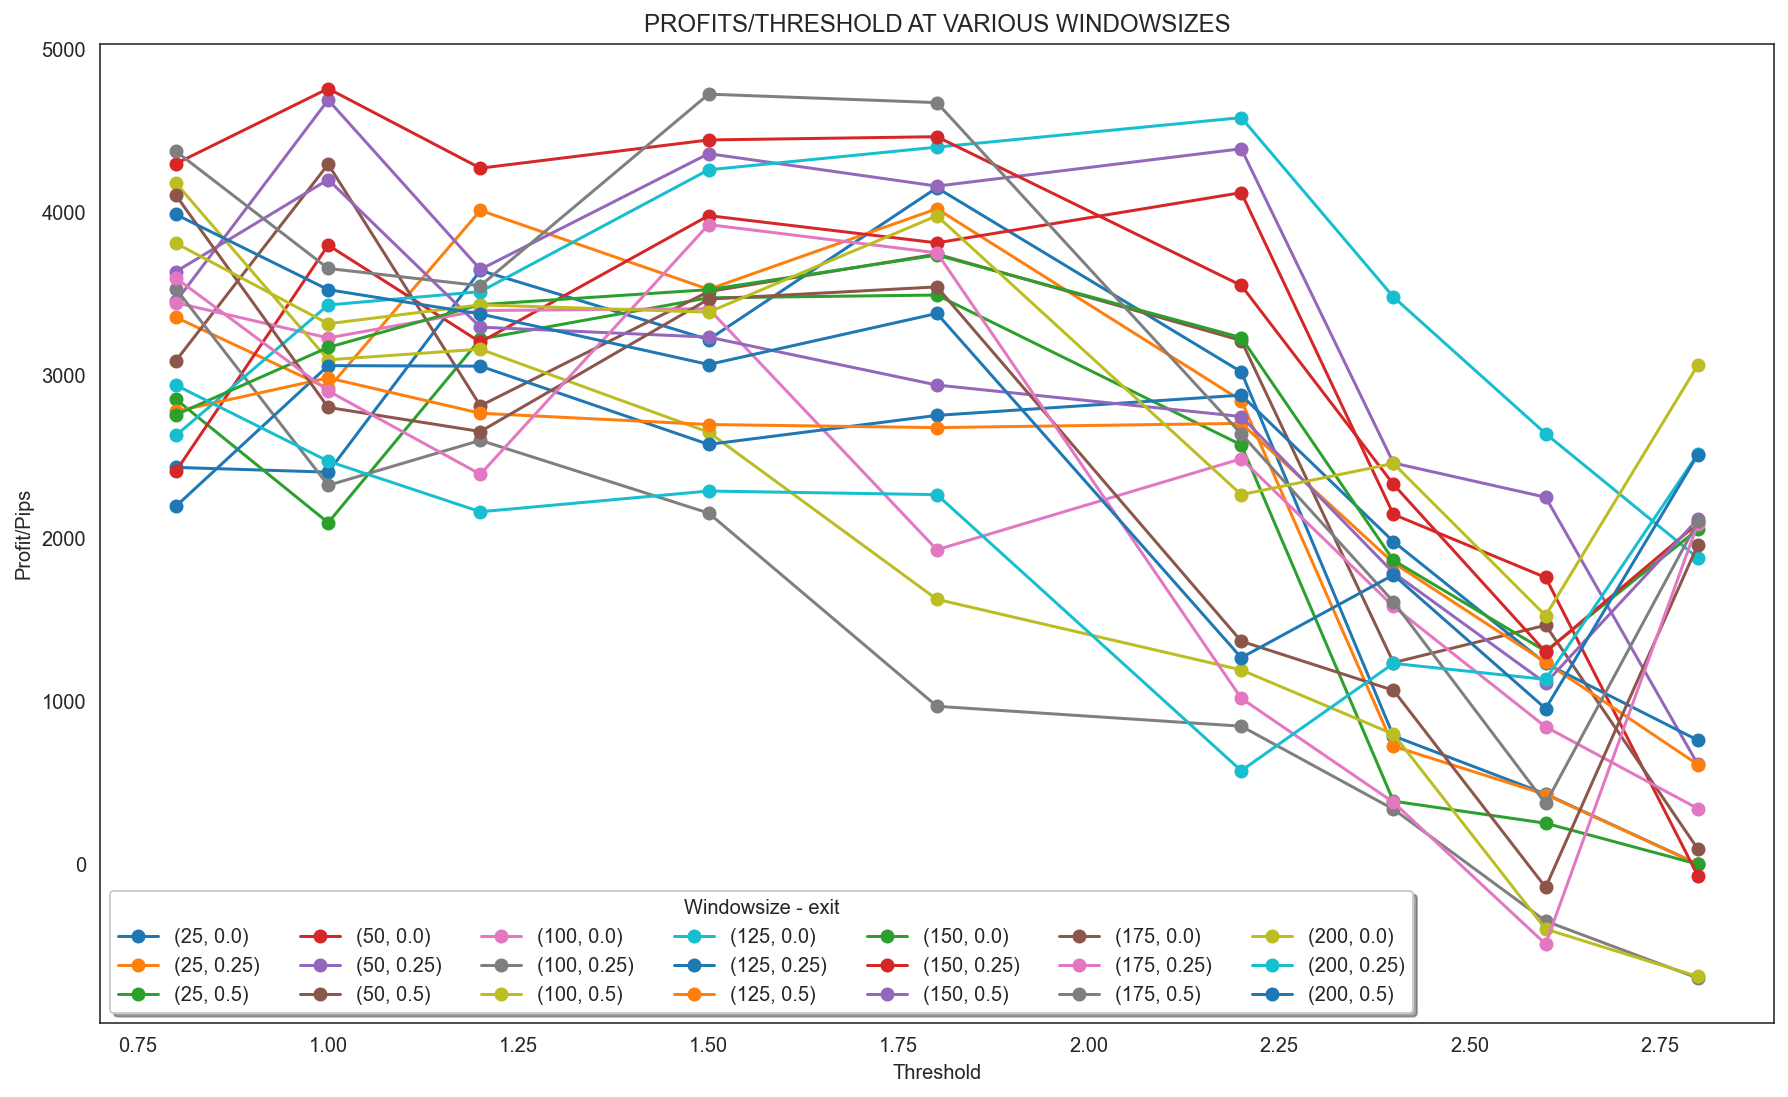

In [28]:
fig,ax = plt.subplots(figsize=(15,9))

hue_variables = ['Windowsize','Exit']
group = profits.groupby(hue_variables)

for group_label, group_df in group:
    ax.plot(group_df['Threshold'], group_df['Profit'], label=group_label, marker='o')
ax.set_xlabel("Threshold")
ax.set_ylabel("Profit/Pips")
ax.legend(title='Windowsize - exit', loc='lower left', ncol=7, fancybox=True, shadow=True)
plt.title("PROFITS/THRESHOLD AT VARIOUS WINDOWSIZES")
plt.savefig('img/Profits.png')
plt.show()

In [29]:
max_values = profits.iloc[profits['Profit'].idxmax(),:]
print(f"The biggest profit, {int(max_values[3])} pips, is gained with a windowsize of {int(max_values[0])} a threshold of {max_values[1]} and exit at {max_values[2]}")

The biggest profit, 4756 pips, is gained with a windowsize of 150 a threshold of 1.0 and exit at 0.25


---
After running all the tests and plottet the result above. In the figure above it's clear that we achieve the biggest profit with a windowsize of 150 (red), a threshold for our Z-score (standard deviation) of 1.0 and exit at 0.25. <br />
One issue with this method of finding the optimal parameters is the risk of overfitting, which is very high in general in timeseries. <br />
That's why it's very important to make the final backtest on a out-of-sample set. Up until now I have only used the dataset up to, and including 2019.
I still have data from 2020 and 2021 to test on.

We can now recreate a model with the paramters and take a closer look at the Z-score to get a better sense of how this strategy works. We can do this by plotting the Z-score with the corresponding entry- and exitpoints for our trades.

Let's use a short period of time as it will be easier to visualize. We will use the first two months of 2017

---

In [30]:
window = 150
threshold = 1
exit = 0.25
YEAR = '2017'
YEAR_END = '2017-2'
pair = ['USDCAD', 'AUDCAD']

p1 = data["USDCAD"].loc[YEAR:YEAR_END,:]
p2 = data["AUDCAD"].loc[YEAR:YEAR_END,:]

Z = CreateModel(p1, p2, pair, window)
trades = TradeEngine(pair, p1, p2,  Z, threshold, window, exit).run()

In [31]:
datetime = pd.Series(p1.iloc[window:,:].index)
datetime = datetime.dt.to_timestamp()
df_formatter = CustomFormatter(datetime)

trades.index = datetime
Z = pd.Series(Z, index=datetime)
entries = Z.mask(trades['USDCAD']['Entry'].isna())
exits = Z.mask(trades['USDCAD']['Exit'].isna())

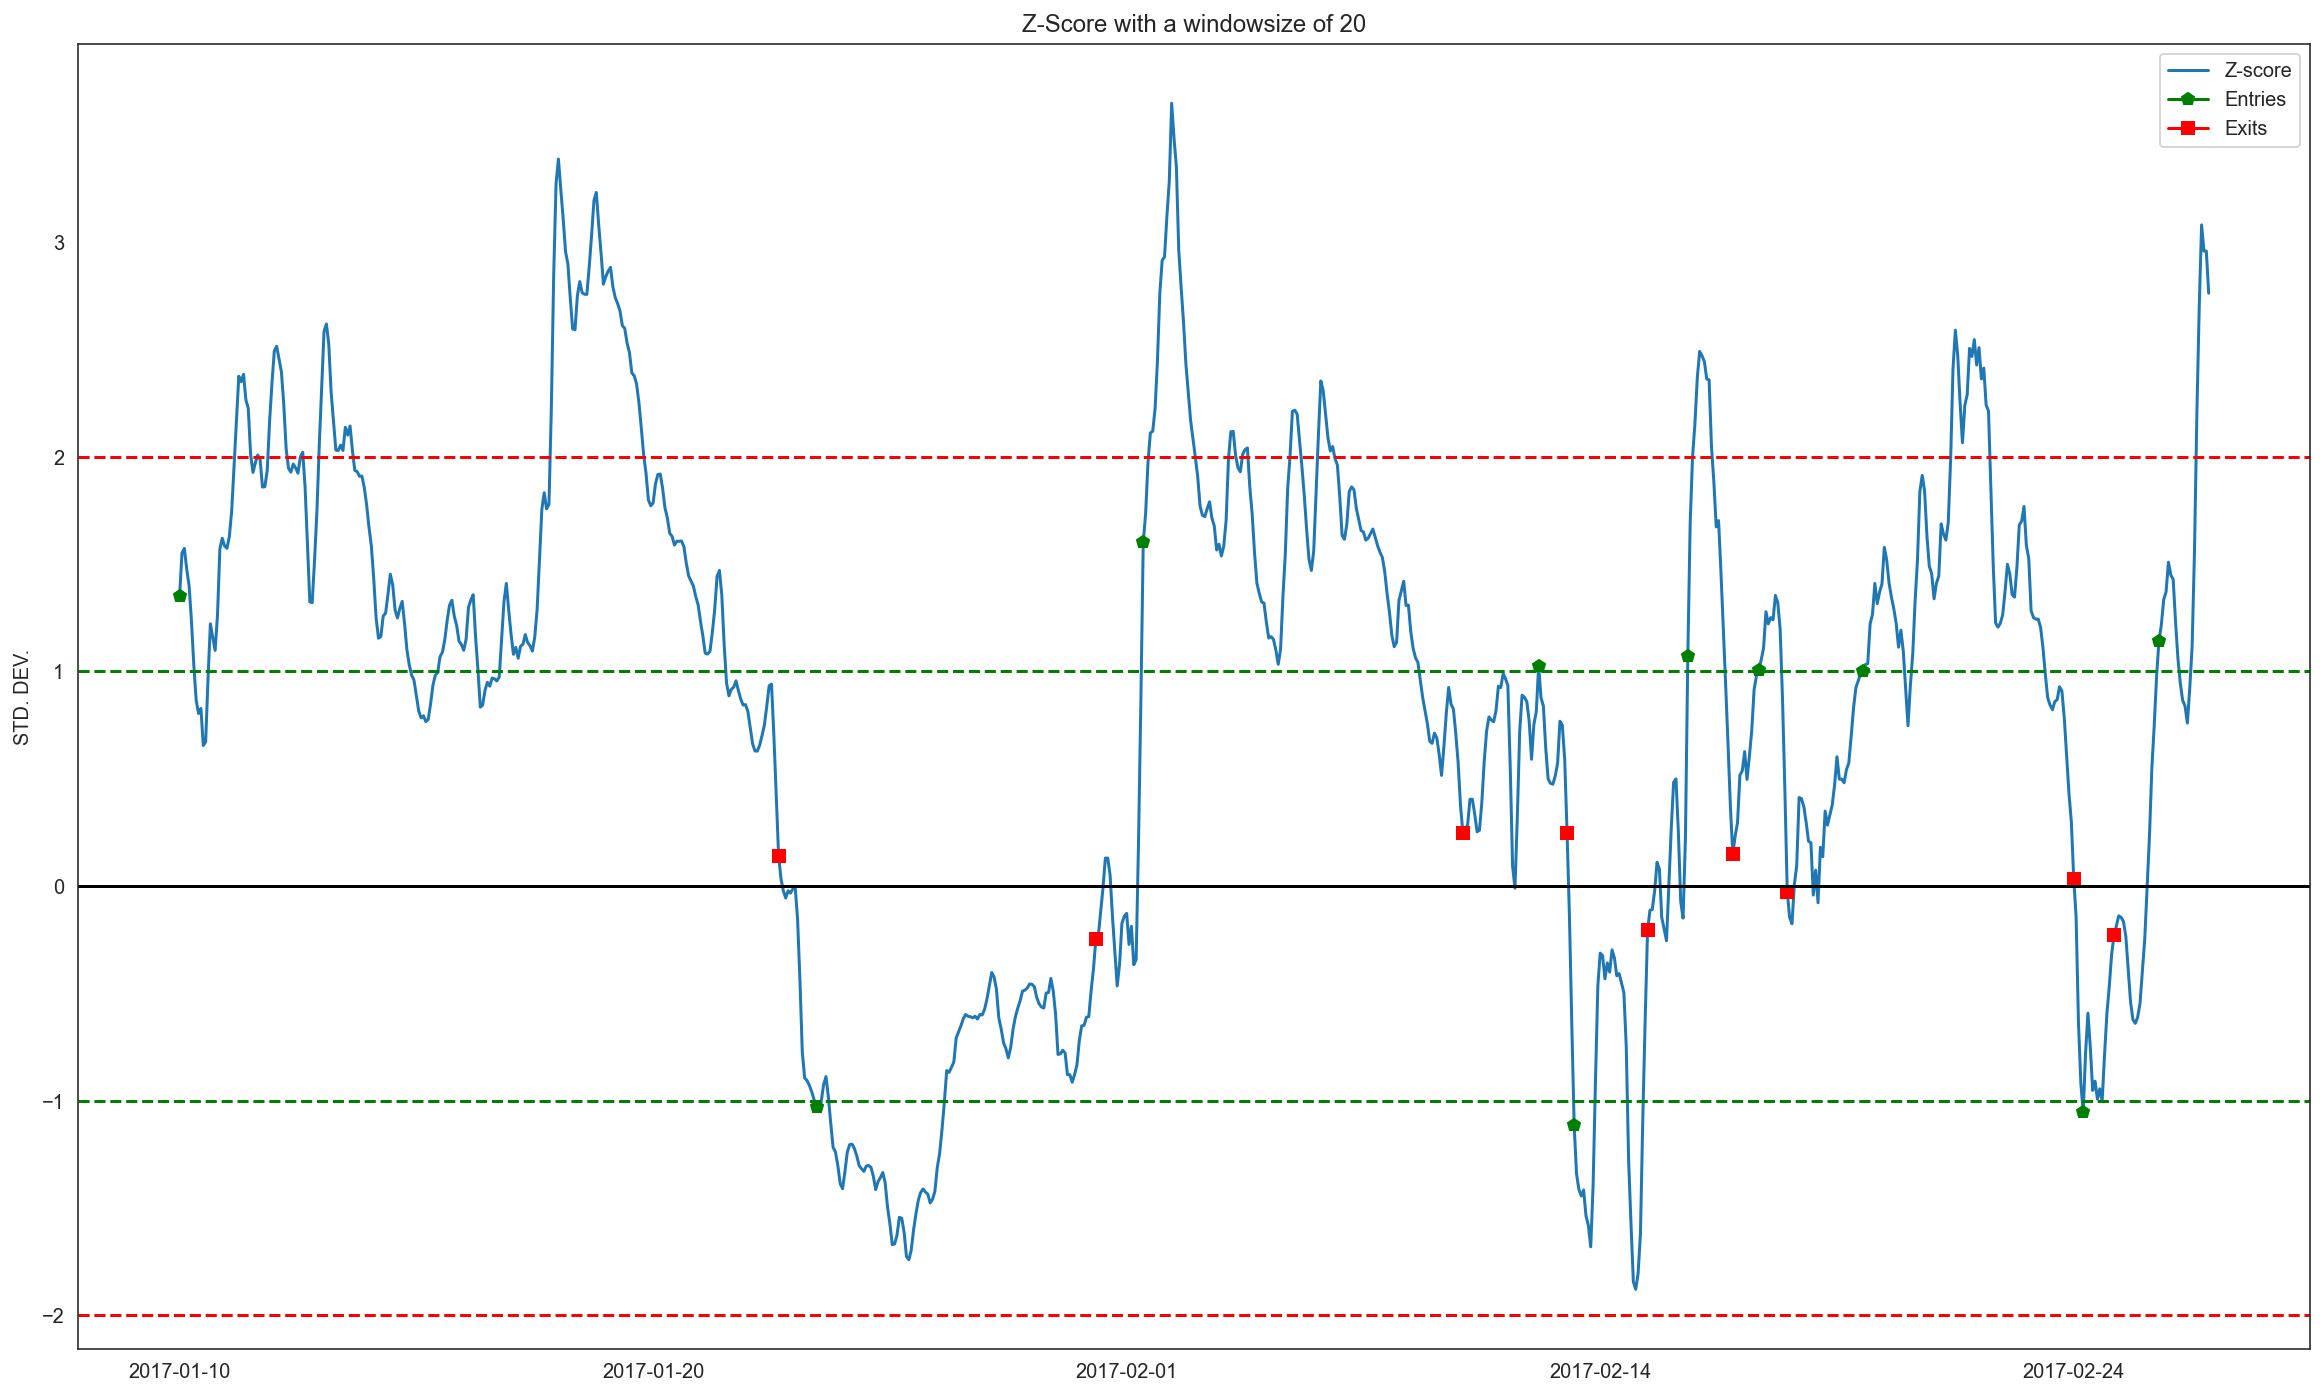

In [32]:
# Plot Z-score and entries/exits
fig, ax = plt.subplots(figsize=(20, 12))
ax.xaxis.set_major_formatter(df_formatter)
ax.plot(Z.values, label='Z-score')
ax.plot(entries.values, color='g', marker='p', label="Entries")
ax.plot(exits.values, color='r', marker='s', label="Exits")
ax.axhline(0, color='black')
ax.axhline(1.0, color='green', linestyle='--')
ax.axhline(-1.0, color='green', linestyle='--')
ax.axhline(2.0, color='red', linestyle='--')
ax.axhline(-2.0, color='red', linestyle='--')
ax.set_ylabel("STD. DEV.")
ax.legend()
ax.set_title("Z-Score with a windowsize of 20")
plt.savefig("img/trades.png")
plt.show()

---
Above is the Z-score plotted and as the value crosses our threshold of +/-1.0 a new trade is opened. -indicated by the green pentagrams. <br />
As the Z-score passes our exit threshold (+/- 0.25) our strategy will close our open trade, if we have any. -indicated by the red square.<br />
The points are not aligned directly on the threshold lines as we only get price updates every hour. But in general the entries <br />
are around the +1 and -1 lines.

---